# Visual tracking arena calibration and testing 
This notebook is a **visual debug tool** to **calibrate and test extrinsics parameters** of the eROBOTICA visual tracking arena. 

**IMPORTANT NOTES**

- The CSV files `camCalib.csv`,`camGround.csv` and `camTest.csv` must be collected via the `serverv2Calib.py`,`serverv2Ground.py` and `serverv2Test.py` codes, respectively (with the `--save` flag). 

- Please just change the variables in the noted cells only.

- All the non-essential and debug only image plots have been commented, but not removed. Feel free to explore them.

- The calibration of intrinsics has already been done with [this repository](https://github.com/debOliveira/myCameraCalibrator) and stored in the file `constants.py`. Please alter the matrices accordingly. 

- All the mathematical basis of this code can be found on the thesis text.

## Configuration 
Just importing libraries and self made functions used in the previous offline arena doodle.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import time,math
import numpy as np
from constants import cameraMat
from cv2 import circle,triangulatePoints,cvtColor,COLOR_GRAY2RGB,computeCorrespondEpilines,putText,FONT_HERSHEY_SIMPLEX,imwrite,Rodrigues
from myLib import isCollinear,isEqual,myProjectionPoints,orderCenterCoord
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import CubicSpline
import os
from myLib import estimateFundMatrix_8norm,decomposeEssentialMat
import cv2
from itertools import permutations,combinations


## Calibration of extrinsincs

The following cell sets up the name of the CSV where the data is stored and the size of the arrays to be read. Alter to the values used with the `serverv2Calib.py` code.

In [49]:
##########################################
### YOU MAY CHANGE THE VARIABLES BELOW ###
##########################################

# name (folder/camCalib.csv) where the CSV from serverv2Calib.py is saved
dfCSV = np.genfromtxt('G:/Meu Drive/UFCG/Mestrado/MoCap/CSV datasets/7Jun/camCalib.csv', delimiter=',')
verbose = False # verbose flag for reading the data and interpolation 
nCameras = 2    # number of cameras
recTime = 90    # recording time, in seconds
step = 1/100    # step of the interpolated DF

### Reading coordinates and ordering markers
Now, we read each line of the CSV that has the following strings:
- *`Ax|Ay|Bx|By|Cx|Cy`*: the x and y undistorted coordinates of each collinear marker A, B or C. 
- *`time`*: the PTS in seconds from when the image was captured.
- *`image number`*: the number of the image in the processing loop at the Raspberry station.
- *`index`*: the number the Raspberry station (varies from 0 to `nCameras`).

Then we check if there was no processing error in the data (e.g. if there is occlusion between markers or PTS divergion). Finally, we check how many images have been missed comparing to the image number of the last valid image from the stream. Note that we may receive delayed packages between Raspberries, but they come always in order from each stream station.

*The markers are ordered using the certainty algorithm proposed in this dissertation.* The timestamp period in which we locate the valid images of each camera's stream is recorded in a separate array and later used for interpolation.

In [50]:
# initiating empty arrays
counter,i,lastTime = np.zeros(nCameras,dtype=np.int32),0,np.zeros(nCameras,dtype=np.int32)
missed,invalid,swap = np.zeros(nCameras,dtype=np.int32),np.zeros(nCameras,dtype=np.int32),np.zeros(nCameras,dtype=np.int32)
lastImgNumber = np.zeros(nCameras,dtype=np.int32)
certainty,intervals,timeIntervals = np.zeros(nCameras,dtype=np.bool8),[],[]
dfOrig,tol = [],0.25
for k in range(nCameras):
    dfOrig.append([])
    intervals.append([])
    timeIntervals.append([])

# reading the CSV per line
while i!=dfCSV.shape[0]:
    line = dfCSV[i]
    # get data from the line
    idx = int(line[8])
    undCoord,time,imgNumber = line[0:6].reshape(-1,2),line[6],line[7]
    i+=1
    # if the timestamp has diverged, discard the image (processing error)
    if counter[idx]:
        if abs(time-lastTime[idx])>1e9: 
            if verbose: print('time missmatch')
            missed[idx]+=1
            invalid[idx]+=1
            continue
    # check if no image was missed
    if imgNumber>lastImgNumber[idx]+1: invalid[idx] = imgNumber-lastImgNumber[idx]
    # check collinearity, occlusion and order markers per proximity
    if isCollinear(*undCoord) and not isEqual(undCoord,5) and not np.any(undCoord<0):     
        if invalid[idx]>=10 or not counter[idx]: 
            if certainty[idx]:
                beg,end = intervals[idx][-1],counter[idx]-1
                timeIntervals[idx].append([dfOrig[idx][beg,6],dfOrig[idx][end,6]])
                if verbose: print('camera #'+str(idx)+' valid from '+str(round(dfOrig[idx][beg,6]/1e6,2))+'s to '+str(round(dfOrig[idx][end][6]/1e6,2))+'s')
            prev,certainty[idx] = [],False
            intervals[idx].append(counter[idx])
        else:
            if not (counter[idx]-1): prev = np.array(dfOrig[idx][0:6]).reshape(-1,2)
            else: prev = np.array(dfOrig[idx][-1,0:6]).reshape(-1,2)
        undCoord, _ = orderCenterCoord(undCoord,prev)
        undCoord = np.array(undCoord)
    else: 
        if verbose: print('not collinear or equal centroids')
        missed[idx]+=1
        invalid[idx]+=1
        continue
    # update datasets variables
    lastTime[idx],lastImgNumber[idx],invalid[idx] = time,imgNumber,0
    if not counter[idx]: dfOrig[idx] = np.hstack((undCoord.reshape(6),time))
    else: dfOrig[idx] = np.vstack((dfOrig[idx],np.hstack((undCoord.reshape(6),time))))
    counter[idx]+=1
    # check if ABC is in order smaller to largest, change if not (but only if certain of the distribution = if at least two images indicate that yes)
    if not certainty[idx]:
        for [A,B,C] in undCoord.reshape([-1, 3, 2]):
            if np.linalg.norm(A-B)/np.linalg.norm(C-B)>(2-tol) and np.linalg.norm(A-B)>20:
                swap[idx] += 1
                if swap[idx]>2:    
                    swap[idx],certainty[idx] = 0,True
                    dfOrig[idx][intervals[idx][-1]:counter[idx],0:2],dfOrig[idx][intervals[idx][-1]:counter[idx],4:6] = np.copy(dfOrig[idx][intervals[idx][-1]:counter[idx],4:6]),np.copy(dfOrig[idx][intervals[idx][-1]:counter[idx],0:2])
            if np.linalg.norm(C-B)/np.linalg.norm(A-B)>(2-tol) and np.linalg.norm(C-B)>20:  certainty[idx] = True

# get last interval validity
for idx in range(nCameras):
    if not len(dfOrig[idx]): continue
    if certainty[idx]:
        beg,end = intervals[idx][-1],counter[idx]-1
        timeIntervals[idx].append([dfOrig[idx][beg,6],dfOrig[idx][end,6]])    
        if verbose: print('camera #'+str(idx)+' valid from '+str(round(dfOrig[idx][beg,6]/1e6,2))+'s to '+str(round(dfOrig[idx][end,6]/1e6,2))+'s')

# outcome
for i in range(nCameras): 
    print('  >> camera '+str(i)+': '+str(len(dfOrig[i]))+' valid images, missed '+str(int(missed[i]))+' images')
            
## debug received centroids  
'''for idx in range(nCameras):
    os.system('rm pics/cam'+str(idx)+'/*')
    for j in range(0,dfOrig[idx].shape[0]):
        pts,name,img,k = dfOrig[idx][j,0:6].reshape(-1,2),int(dfOrig[idx][j,6]),np.ones((540,960,3))*255,0
        for k in range(0,3):
            pt = pts.reshape(-1,2)[k]
            center = (int(np.round(pt[0]*16)),int(np.round(pt[1]*16)))
            circle(img,center,10,(255,0,0),5,shift=4)
            putText(img,str(k),(int(center[0]/16)-25, int(center[1]/16)-25),FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2) 
        imwrite('pics/cam'+str(idx+1)+'/'+str(name).zfill(20)+'.jpg',img)''';


  >> camera 0: 2717 valid images, missed 166 images
  >> camera 1: 2596 valid images, missed 351 images


### Computing the extrinsics parameters

Having the centroids ordered, we can interpolate all cameras to a common database and triangulate the markers within the valid time intervals. Then we estimate the fundamental and essential matrices, which can be decomposed to rotation and translation between cameras.

It is known that the best calibration result is obtained from cameras that have 90 degrees difference between them. Therefore, we only calibrated sequential pairs (i.g. (0,1), (1,2), (2,3), ...). A bundle adjustment should be added for a larger number of cameras.

interpolated 5395 images between cams 0 and 1
[INFO] Computing fundamental and essential matrix between cameras 0-1
	Scale between real world and triang. point cloud is:  398.86
	L_AC >> mean = 15.6606cm, std. dev = 0.2659cm, rms = 0.2688cm
	L_AB >> mean = 5.5821cm, std. dev = 0.0953cm, rms = 0.1258cm
	L_BC >> mean = 10.0869cm, std. dev = 0.1979cm, rms = 0.2279cm
	Images distant more than 1% from the real value = 2947/5395
[INFO] Refining fundamental matrix estimation
	Scale between real world and triang. point cloud is:  400.1
	L_AC >> mean = 15.6591cm, std. dev = 0.0771cm, rms = 0.0873cm
	L_AB >> mean = 5.5761cm, std. dev = 0.0563cm, rms = 0.0947cm
	L_BC >> mean = 10.0905cm, std. dev = 0.0713cm, rms = 0.1307cm


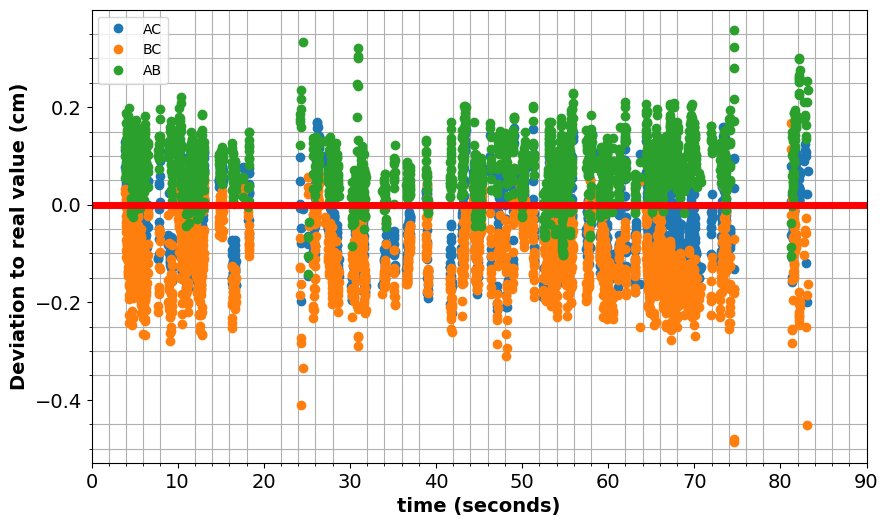

--


In [51]:
# initiating empty arrays
rotation,translation,scale,FMatrix,points3D_perPair,firCentroids,secCentroids = [np.identity(3)],[np.zeros((1,3))],[[1]],[],[],[],[]
allIdx = [(i,i+1) for i in range(nCameras-1)]           # list of sequential pairs (0,1),(1,2),(2,3)...
#allIdx = list(combinations(list(range(nCameras)),2))   # list of all possible pairs

# setting up plotting function for epipolar lines
from cv2 import line
def drawlines(img1,img2,lines,pts1,pts2):
    r,c = img1.shape
    img1 = cvtColor(img1.astype('float32'),COLOR_GRAY2RGB)
    img2 = cvtColor(img2.astype('float32'),COLOR_GRAY2RGB)
    listColors = [(0,0,255),(0,255,0),(255,0,0)]
    i = 0
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = listColors[i]
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = circle(img1,tuple(pt1),5,color,-1)
        img2 = circle(img2,tuple(pt2),5,color,-1)
        i+=1
    return img1,img2

# calibration loop for a pair of sequential cameras
for [m,n] in allIdx:
    # compute valid time intersection for interpolation
    intersections = [[max(first[0], second[0]), min(first[1], second[1])]  
                        for first in timeIntervals[m] for second in timeIntervals[n]  
                        if max(first[0], second[0]) <= min(first[1], second[1])]
    # create and fill inteprolation dataset based on the intersection of valid time intervals 
    dfInterp = np.zeros((int(recTime/step),2*6+1))
    dfInterp[:,-1] = np.arange(0,recTime,step)
    for [beg,end] in intersections:
        for idx in [m,n]:
            validIdx = [i for i in range(0,dfOrig[idx].shape[0]) if beg<=dfOrig[idx][i,-1]<=end]
            coord,time = dfOrig[idx][validIdx,0:6],dfOrig[idx][validIdx,6]/1e6
            if time.shape[0]<=2: continue
            lowBound,highBound = math.ceil(time[0]/step),math.floor(time[-1]/step)
            if verbose: print('interpolated #'+str(idx+1)+' from '+str(round(lowBound*step,2))+'s to '+str(round(highBound*step,2))+'s')
            tNew = np.linspace(lowBound,highBound,int((highBound-lowBound))+1,dtype=np.uint16)
            if time.shape[0]<=2: continue
            ff = CubicSpline(time,coord,axis=0)
            if idx == m: dfInterp[tNew,0:6] = ff(tNew*step)
            else: dfInterp[tNew,6:12] = ff(tNew*step)
    # get data from the interpolation dataset
    dfInterp = np.delete(dfInterp,np.unique([i for i in range(0,dfInterp.shape[0]) for idx in range(2) if not np.any(dfInterp[i][idx*6:idx*6+6])]),axis=0)
    if dfInterp.shape[0] < 10: 
        print('[ERROR] no valid image intersection for cameras '+str(m)+' and '+str(n))
        break
    centroids1,centroids2 = dfInterp[:,0:6].reshape(-1,2),dfInterp[:,6:12].reshape(-1,2)
    print('interpolated '+str(dfInterp.shape[0])+' images between cams '+str(m)+' and '+str(n))
    # estimate fundamental and essential matrices 
    print('[INFO] Computing fundamental and essential matrix between cameras '+str(m)+'-'+str(n))
    F,_ = estimateFundMatrix_8norm(np.array(centroids1),np.array(centroids2),verbose=verbose)
    E = np.matmul(cameraMat[n].T, np.matmul(F, cameraMat[m]))
    if verbose: print("\nEssenc. Mat.\n", E.round(4))
    # decompose to rotation and translation between cameras
    R, t = decomposeEssentialMat(E, cameraMat[m], cameraMat[n], np.array(centroids1), np.array(centroids2))
    if np.any(np.isnan(R)): print('no valid rotation matrix')
    else:
        if verbose:
            print("\nRot. Mat.\n", R.round(4))
            print("\nTrans. Mat.\n", t.round(4))
    # create projection matrices and triangulate to compute scale
    P1,P2 = np.hstack((cameraMat[m], [[0.], [0.], [0.]])),np.matmul(cameraMat[n], np.hstack((R, t.T)))
    projPt1,projPt2 = myProjectionPoints(np.array(centroids1)),myProjectionPoints(np.array(centroids2))
    points4d = triangulatePoints(P1.astype(float),P2.astype(float),projPt1.astype(float),projPt2.astype(float))
    points3d = (points4d[:3, :]/points4d[3, :]).T
    if points3d[0, 2] < 0: points3d = -points3d
    tot,L_real_AC,L_real_AB,L_real_BC,L_AC_vec,L_BC_vec,L_AB_vec,k,false_idx,time_idx = 0,15.7,5.5,10.2,[],[],[],0,[],[]
    # compute sdt deviation and plot beautiful stuff
    for [A, B, C] in points3d.reshape([-1, 3, 3]):
        L_rec_AC,L_rec_BC,L_rec_AB = np.linalg.norm(A-C),np.linalg.norm(B-C),np.linalg.norm(A-B)
        tot = tot + L_real_AC/L_rec_AC + L_real_BC/L_rec_BC + L_real_AB/L_rec_AB
        k = k + 3
        L_AC_vec.append(L_rec_AC)
        L_BC_vec.append(L_rec_BC)
        L_AB_vec.append(L_rec_AB)   
    lamb = tot/k
    print('\tScale between real world and triang. point cloud is: ', lamb.round(2))
    print('\tL_AC >> mean = ' + str((np.mean(L_AC_vec)*lamb).round(4)) + "cm, std. dev = " + str((np.std(L_AC_vec)*lamb).round(4)) +
        "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_AC_vec)*lamb-L_real_AC)))).round(4)) + "cm")
    print('\tL_AB >> mean = ' + str((np.mean(L_AB_vec)*lamb).round(4)) + "cm, std. dev = " + str((np.std(L_AB_vec)*lamb).round(4)) +
        "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_AB_vec)*lamb-L_real_AB)))).round(4)) + "cm")
    print('\tL_BC >> mean = ' + str((np.mean(L_BC_vec)*lamb).round(4)) + "cm, std. dev = " + str((np.std(L_BC_vec)*lamb).round(4)) +
        "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_BC_vec)*lamb-L_real_BC)))).round(4)) + "cm")
    # debug plot for error before refiment
    '''fig = plt.figure(figsize=(10, 6), dpi=200)
    L_AC_vec_plot,L_BC_vec_plot,L_AB_vec_plot = np.array(L_AC_vec)*lamb - L_real_AC,np.array(L_BC_vec)*lamb - L_real_BC,np.array(L_AB_vec)*lamb - L_real_AB
    plt.plot(dfInterp[:,-1],L_AC_vec_plot, 'o', label="AC")
    plt.plot(dfInterp[:,-1],L_BC_vec_plot, 'o', label="BC")
    plt.plot(dfInterp[:,-1],L_AB_vec_plot, 'o', label="AB")
    plt.axhline(y=0.0, color='r', linestyle='-',linewidth=5)
    plt.grid()
    plt.xlabel("time (seconds)",fontsize=14, fontweight='bold')
    plt.ylabel("Deviation to real value (cm)",fontsize=14,fontweight='bold')
    plt.legend()
    ax = fig.axes
    ax[0].minorticks_on()
    plt.grid(which='both')
    plt.xlim(0,recTime)
    plt.rc('xtick',labelsize=14)
    plt.rc('ytick',labelsize=14)
    plt.draw()
    plt.show()'''
    # getting indexes of images where the AC markers are further than 1% of the real distance
    points3d_new,i,k= points3d*lamb,0,0
    for [A, B, C] in points3d_new.reshape([-1, 3, 3]):
        L_reconst = np.sqrt(np.sum((A-C)**2, axis=0))
        valid = abs(L_real_AC-L_reconst)/L_real_AC < 0.01
        if not valid: 
            i = i + 1
            false_idx.extend((k,k+1,k+2))
            time_idx.append(int(k/3))
        k+=3
    print("\tImages distant more than 1% from the real value = " + str(i)+'/'+str(int(points3d.shape[0]/3)))
    # deleting points and refining estimation of the fundamental and essential matrices
    print("[INFO] Refining fundamental matrix estimation")
    centroids1,centroids2,dfInterp=np.delete(centroids1,false_idx,axis=0),np.delete(centroids2,false_idx,axis=0),np.delete(dfInterp,time_idx,axis=0)
    F,_ = estimateFundMatrix_8norm(np.array(centroids1),np.array(centroids2),verbose = 0)
    E = np.matmul(cameraMat[n].T, np.matmul(F, cameraMat[m]))
    if verbose: print("\nEssenc. Mat.\n", E.round(4))
    # decompose to rotation and translation between cameras
    R, t = decomposeEssentialMat(E, cameraMat[m], cameraMat[n], np.array(centroids1), np.array(centroids2))
    if np.any(np.isnan(R)): print('no valid rotation matrix')
    else:
        if verbose:
            print("\nRot. Mat.\n", R.round(4))
            print("\nTrans. Mat.\n", t.round(4))
    P1,P2 = np.hstack((cameraMat[m], [[0.], [0.], [0.]])),np.matmul(cameraMat[n], np.hstack((R, t.T)))
    projPt1,projPt2 = myProjectionPoints(np.array(centroids1)),myProjectionPoints(np.array(centroids2))
    points4d = triangulatePoints(P1.astype(float),P2.astype(float),projPt1.astype(float),projPt2.astype(float))
    points3d = (points4d[:3, :]/points4d[3, :]).T
    if points3d[0, 2] < 0: points3d = -points3d
    tot,L_real_AC,L_real_AB,L_real_BC,L_AC_vec,L_BC_vec,L_AB_vec,k,false_idx = 0,15.7,5.5,10.2,[],[],[],0,[]
    # compute sdt deviation and plot beautiful stuff
    for [A, B, C] in points3d.reshape([-1, 3, 3]):
        L_rec_AC,L_rec_BC,L_rec_AB = np.linalg.norm(A-C),np.linalg.norm(B-C),np.linalg.norm(A-B)
        tot = tot + L_real_AC/L_rec_AC + L_real_BC/L_rec_BC + L_real_AB/L_rec_AB
        k = k + 3
        L_AC_vec.append(L_rec_AC)
        L_BC_vec.append(L_rec_BC)
        L_AB_vec.append(L_rec_AB)   
    lamb = tot/k
    print('\tScale between real world and triang. point cloud is: ', lamb.round(2))
    print('\tL_AC >> mean = ' + str((np.mean(L_AC_vec)*lamb).round(4)) + "cm, std. dev = " + str((np.std(L_AC_vec)*lamb).round(4)) +
        "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_AC_vec)*lamb-L_real_AC)))).round(4)) + "cm")
    print('\tL_AB >> mean = ' + str((np.mean(L_AB_vec)*lamb).round(4)) + "cm, std. dev = " + str((np.std(L_AB_vec)*lamb).round(4)) +
        "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_AB_vec)*lamb-L_real_AB)))).round(4)) + "cm")
    print('\tL_BC >> mean = ' + str((np.mean(L_BC_vec)*lamb).round(4)) + "cm, std. dev = " + str((np.std(L_BC_vec)*lamb).round(4)) +
        "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_BC_vec)*lamb-L_real_BC)))).round(4)) + "cm")
    # debug plot for error after refiment
    fig = plt.figure(figsize=(10, 6), dpi=100)
    L_AC_vec_plot,L_BC_vec_plot,L_AB_vec_plot = np.array(L_AC_vec)*lamb - L_real_AC,np.array(L_BC_vec)*lamb - L_real_BC,np.array(L_AB_vec)*lamb - L_real_AB
    plt.plot(dfInterp[:,-1],L_AC_vec_plot, 'o', label="AC")
    plt.plot(dfInterp[:,-1],L_BC_vec_plot, 'o', label="BC")
    plt.plot(dfInterp[:,-1],L_AB_vec_plot, 'o', label="AB")
    plt.axhline(y=0.0, color='r', linestyle='-',linewidth=5)
    plt.grid()
    plt.xlabel("time (seconds)",fontsize=14, fontweight='bold')
    plt.ylabel("Deviation to real value (cm)",fontsize=14,fontweight='bold')
    plt.legend()
    ax = fig.axes
    ax[0].minorticks_on()
    plt.grid(which='both')
    plt.xlim(0,recTime)
    plt.rc('xtick',labelsize=14)
    plt.rc('ytick',labelsize=14)
    plt.draw()
    plt.show()
    # saving extrinsics parameters to later use
    translation.append(t)
    rotation.append(R)
    scale.append([lamb])
    FMatrix.append(F)
    points3D_perPair.append(points3d)
    firCentroids.append(centroids1)
    secCentroids.append(centroids2)
    # epipolar lines plot  
    '''img1,img2,n = np.ones((720,960))*255,np.ones((720,960))*255,0
    pts1,pts2 = np.int32(centroids1[n:n+3].reshape(-1,2)),np.int32(centroids2[n:n+3].reshape(-1,2))
    lines1 = computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
    lines1 = lines1.reshape(-1,3)
    img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
    lines2 = computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
    lines2 = lines2.reshape(-1,3)
    img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
    plt.figure(figsize=(20, 16),dpi=100)
    plt.subplot(121),plt.imshow(img5.astype(np.uint8))
    plt.subplot(122),plt.imshow(img3.astype(np.uint8))
    plt.show()'''
    print('--')


### Update reference to the 0th camera

With the rotation and translation in scale between cameras, we have to compound the rigid body transformations and obtain the pose of each camera in relation to the 0th camera. The triangulated 3D points must also be rotated and translated in reference to the world origin.

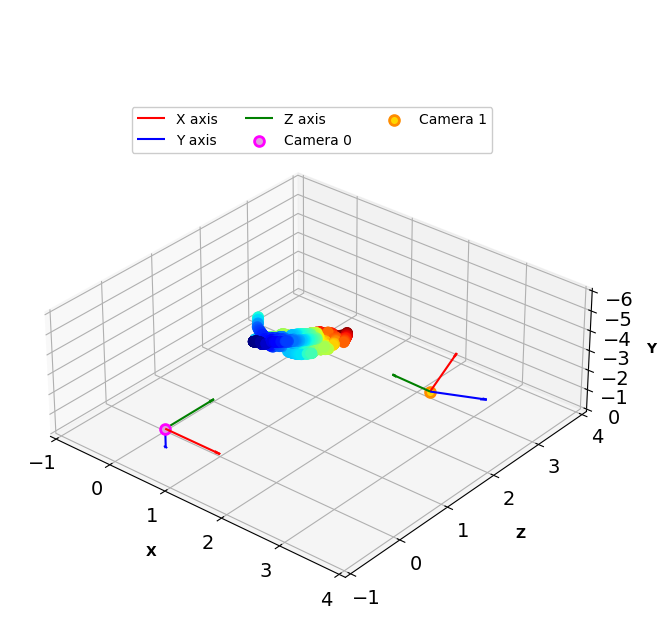

In [52]:
# setting 3D plot variables
fig = plt.figure(figsize=(8, 8),dpi=100)
ax = plt.axes(projection='3d')
ax.set_xlim(-1, 4)
ax.set_zlim(-6, 0)
ax.set_ylim(-1, 4)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_xlabel('X', fontweight='bold',labelpad=15)
ax.set_ylabel('Z', fontweight='bold',labelpad=15)
ax.set_zlabel('Y', fontweight='bold',labelpad=5)
cmhot = plt.get_cmap("jet")
ax.view_init(elev=30, azim=-50) 
plt.gca().invert_zaxis()
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1., 1., .5, 1.]))
colours = [['fuchsia','plum'],['darkorange','gold'],['limegreen','greenyellow'],['blue','lightsteelblue']]

# initializing arrays
allPts3d,projMat = [],[]

# getting coordinates from each camera and 3D points in relation to the 0th camera
for j in range(nCameras):
    # initialize initial values of the projection matrices
    x,y,z= np.array([1, 0, 0, 0]), np.array([0, 1, 0, 0]),np.array([0, 0, 1, 0])
    P_new = np.vstack((np.hstack((np.identity(3),np.zeros((3,1)))),np.hstack((np.zeros((3)),1))))
    # iterate over the previous cameras to find the relation to the 0th camera
    # e.g. 3 -> 2 -> 1 -> 0
    for i in np.flip(range(j+1)):
        t,R,lamb = np.array(translation[i][0]).reshape(-1,3),np.array(rotation[i]),scale[i]
        t_new = np.matmul(-t, R).reshape(-1,3)*lamb/100
        P = np.vstack((np.hstack((R.T,t_new.T)),np.hstack((np.zeros((3)),1))))
        P_new = np.matmul(P,P_new)
    # save new projection matrix
    projMat.append(P_new)
    # plot camera pose
    x,y,z = np.matmul(P_new,x),np.matmul(P_new,y),np.matmul(P_new,z)
    o = np.matmul(P_new,[[0.],[0.],[0.],[1]]).ravel()
    ax.quiver(o[0], o[2], o[1], x[0], x[2], x[1], arrow_length_ratio=0.1, edgecolors="r", label='X axis')
    ax.quiver(o[0], o[2], o[1], y[0], y[2], y[1], arrow_length_ratio=0.1, edgecolors="b", label='Y axis')
    ax.quiver(o[0], o[2], o[1], z[0], z[2], z[1], arrow_length_ratio=0.1, edgecolors="g", label='Z axis')
    ax.scatter(o[0], o[2], o[1], s=50, edgecolor=colours[j][0], facecolor=colours[j][1], linewidth=2,  label = 'Camera '+str(j))
    # save triangulated 3D points in relation to the 0th camera
    if j<(nCameras-1):
        points3d = np.hstack((points3D_perPair[j]*scale[j+1][0]/100,np.ones((points3D_perPair[j].shape[0],1)))).T
        points3d = np.matmul(P_new,points3d)
        ax.scatter(points3d[0], points3d[2], points3d[1], s=50, c=points3d[2], cmap=cmhot)
        if not len(allPts3d): allPts3d = points3d.copy()
        else: allPts3d = np.hstack((allPts3d,points3d.copy()))

# final plot commands
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),ncol=3,loc ='center',edgecolor='silver', bbox_to_anchor=(0.5, 0.8))
plt.draw()
plt.show()

### Global bundle adjustment

For a larger number of cameras, you may use optimzation to minimize the reprojection error. It would be ideal to have the same number of points between each camera pair, which could be achieved using clusterization or a weighted regression. Thus, this is a non-linear weighted sparse least squares problem. A solution was derived from [this `scipy` project](https://scipy-cookbook.readthedocs.io/items/bundle_adjustment.html).  

In [53]:
from scipy.sparse import lil_matrix
from scipy.optimize import least_squares

# Computing the 2D reprojection from a 3D point >> x = PX
def reproject(points3d,cameraParams):
    camCoef,rod,t,R  = cameraParams[:,0:4],cameraParams[:,4:7].reshape(-1,3,1),cameraParams[:,7:10].reshape(-1,3,1),[]
    for r in rod: R.append(Rodrigues(r)[0])
    R = np.array(R).reshape(-1,3,3)
    nPts = camCoef.shape[0]
    K = np.transpose(np.array([[camCoef[:,0],np.zeros(nPts),camCoef[:,2]],
                  [np.zeros(nPts),camCoef[:,1],camCoef[:,3]], 
                  [np.zeros(nPts),np.zeros(nPts),np.ones(nPts)]]),(2,0,1)) 
    P = np.matmul(K,np.dstack((R, t)))
    newPts3D = np.transpose(np.hstack((points3d,np.ones((points3d.shape[0],1)))).reshape(-1,1,4),(0,2,1))
    newPts = np.matmul(P,newPts3D)
    pts2D = newPts[:,0:2,:]/newPts[:,2,:].reshape(-1,1,newPts.shape[-1])
    return np.transpose(pts2D,(0,2,1)).reshape(-1,2)

# residual computation formula >> x_reprojected - x_measured
def reprojectionError(params,nCameras,points_2d,cameraIdx,pointIdx,weights):
    cameraParams = params[:nCameras*10].reshape(-1, 10)
    points_3d = params[nCameras*10:].reshape(-1, 3)
    points_proj = reproject(points_3d[pointIdx.astype(int)], cameraParams[cameraIdx.astype(int)])
    return np.multiply(weights,points_proj - points_2d).ravel()

# sparse matrix (the 0th camera stays at the origin)
def bundle_adjustment_sparsity(nCameras,nPts,camIdx,pointIdx):
    m = camIdx.size*2
    n = nCameras*10+nPts*3
    A = lil_matrix((m, n), dtype=int)
    i = np.arange(camIdx.size)
    for s in range(4,10):
        A[2*i[int(camIdx.size/2):],10+s] = 1
        A[2*i[int(camIdx.size/2):]+1,10+s] = 1
    for s in range(3):
        A[2*i,nCameras*10+pointIdx*3+s] = 1
        A[2*i+1,nCameras*10+pointIdx*3+s] = 1
    A[:,0:10] = 0
    return A     

# initiating arrays
cameraParams,points3d,points2d,cameraIdx,pointIdx,weights = [],[],[],[],[],[]
# setting camera parameters to shape using rodrigues vectors
for i in range(nCameras): 
    K = cameraMat[i]
    P = projMat[i].copy()    
    R = P[0:3,0:3].T
    lamb = np.linalg.norm(P[0:3,3])*100
    if not lamb: t = np.matmul(-np.copy(P[0:3,3]),R.T).reshape(-1,3)
    else: t = np.matmul(-np.copy(P[0:3,3]*100/lamb),R.T).reshape(-1,3)*lamb/100
    #if i==1: P = np.matmul(K,np.hstack((R, t.T)))
    if not len(cameraParams): cameraParams=np.hstack((np.array([K[0][0],K[1][1],K[0][2],K[1][2]]).reshape(-1,4),Rodrigues(R)[0].reshape(-1,3),t.reshape(-1,3)))
    else: cameraParams=np.vstack((cameraParams,np.hstack((np.array([K[0][0],K[1][1],K[0][2],K[1][2]]).reshape(-1,4),Rodrigues(R)[0].reshape(-1,3),t.reshape(-1,3)))))
x = np.hstack((cameraParams.ravel(), allPts3d[0:3].T.ravel()))
# setting indexes and weight variables to shape
for i in range(len(allIdx)):
    new2dPts = np.vstack((firCentroids[i],secCentroids[i]))
    [m,n]=allIdx[i]
    if not len(points2d): 
        points2d = new2dPts.copy()
        cameraIdx = np.hstack((np.ones(firCentroids[i].shape[0])*m,np.ones(secCentroids[i].shape[0])*n))
        weights = np.ones(firCentroids[i].shape[0]*2)/(firCentroids[i].shape[0]*2)
        pointIdx = np.hstack(([i for i in range(firCentroids[i].shape[0])],[i for i in range(secCentroids[i].shape[0])]))
    else: 
        points2d = np.vstack((points2d,new2dPts.copy()))
        cameraIdx = np.hstack((cameraIdx,np.ones(firCentroids[i].shape[0])*m,np.ones(secCentroids[i].shape[0])*n))
        offset = pointIdx[-1]+1
        weights = np.hstack((weights,np.ones(firCentroids[i].shape[0]*2)/(firCentroids[i].shape[0]*2)))
        pointIdx = np.hstack((pointIdx,np.hstack(([i for i in range(offset,offset+firCentroids[i].shape[0])],
                                                    [i for i in range(offset,offset+secCentroids[i].shape[0])]))))
weights = (weights*cameraIdx.shape[0]).reshape(-1,1)
# Least squares (but not weighted)
r = reprojectionError(x,nCameras,points2d,cameraIdx,pointIdx,np.ones_like(weights))
A = bundle_adjustment_sparsity(nCameras,allPts3d.shape[1],cameraIdx,pointIdx)
res = least_squares(reprojectionError, x, jac_sparsity=A, verbose=0, x_scale='jac', ftol=1e-6, method='trf',
                    args=(nCameras,points2d,cameraIdx,pointIdx,np.ones_like(weights)))

# plot debug 
# plt.plot(r,label='initial residue')                    
# plt.plot(res.fun,label='optimized residue')
print('Before optimization reprojection error (in pixels): ')
print('\tMean:',r.mean())
print('\tStd. dev. :',r.std())
print('\tMin:',r.min())
print('\tMax:',r.max())
r = reprojectionError(res.x,nCameras,points2d,cameraIdx,pointIdx,np.ones_like(weights))
print('After optimization reprojection error (in pixels): ')
print('\tMean:',r.mean())
print('\tStd. dev. :',r.std())
print('\tMin:',r.min())
print('\tMax:',r.max())

Before optimization reprojection error (in pixels): 
	Mean: -1.1665079872907724
	Std. dev. : 2.6578366225328565
	Min: -6.0820543928583675
	Max: 5.441238985405846
After optimization reprojection error (in pixels): 
	Mean: -0.6200169585864471
	Std. dev. : 1.5506297564240181
	Min: -6.415183251904807
	Max: 3.380322407888798


## Calibration of ground plane

The following cell sets up the name of the CSV where the data is stored and the size of the arrays to be read. Alter to the values used with the `serverv2Ground.py` code.

In [54]:
##########################################
### YOU MAY CHANGE THE VARIABLES BELOW ###
##########################################

# name (folder/camGround.csv) where the CSV from serverv2Ground.py is saved
dfCSV = np.genfromtxt('G:/Meu Drive/UFCG/Mestrado/MoCap/CSV datasets/7Jun/camGround.csv', delimiter=',')

In [56]:
#########################
### Utility functions ###
#########################

# check if there is occlusion
def isEqual4(pt,tol=5):
    A,B,C,D = pt[0],pt[1],pt[2],pt[3]
    AB,AC,BC = np.linalg.norm(A-B),np.linalg.norm(A-C),np.linalg.norm(C-B)
    AD,BD,CD = np.linalg.norm(A-D),np.linalg.norm(B-D),np.linalg.norm(C-D)
    return min(AB,AC,BC,AD,BD,CD)<tol

# get epiline coeficients based on the fundamental matrix
def getEpilineCoef(pts,F):
    [a,b,c]=np.matmul(F,np.hstack((pts,1))) #ax+by+c=0
    return [a,b,c]/(np.sqrt(pow(a,2)+pow(b,2)))

# get the distance between a point and a line
def getDistance2Line(lines,pts):
    pts,out,lines = np.copy(pts).reshape(-1,2),[],np.copy(lines).reshape(-1,3)
    for [a,b,c] in lines:
        for [x,y] in pts: out.append(abs(a*x+b*y+c)/np.sqrt(np.sqrt(pow(a,2)+pow(b,2))))
    return np.array(out)<5,np.array(out)    

# find a plane that passes between three points
def findPlane(A,C,D):
    x1,y1,z1 = A
    x2,y2,z2 = C
    x3,y3,z3 = D
    a1,b1,c1 = x2-x1,y2-y1,z2-z1
    a2,b2,c2 = x3-x1,y3-y1,z3-z1
    a,b,c = b1*c2-b2*c1,a2*c1-a1*c2,a1*b2-b1*a2
    d=(-a*x1-b*y1-c*z1)
    return np.array([a,b,c,d])

# draw epipolar lines with numbers
def drawlines(img1,img2,lines,pts1,pts2):    
    r,c = img1.shape
    img1 = cvtColor(img1.astype('float32'),COLOR_GRAY2RGB)
    img2 = cvtColor(img2.astype('float32'),COLOR_GRAY2RGB)
    listColors = [(0,0,255),(0,255,0),(255,0,0),(255,0,255)]
    i = 0
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = listColors[i]
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = circle(img1,tuple(pt1),5,color,-1)
        putText(img1,str(i),tuple(pt1-20),FONT_HERSHEY_SIMPLEX,0.5,color,2) 
        img2 = circle(img2,tuple(pt2),5,color,-1)
        putText(img2,str(i),tuple(pt2-20),FONT_HERSHEY_SIMPLEX,0.5,color,2) 
        i+=1
    return img1,img2

# ordering approach using epiline proximity
def getOrderPerEpiline(coord1,coord2,nMarkers,F,verbose = 0,retValue = 0):
    # get data
    pts1,pts2,orderSecondFrame = np.copy(coord1).reshape(-1,2),np.copy(coord2).reshape(-1,2),np.ones(nMarkers,dtype=np.int8)*-1
    epilines = np.zeros((nMarkers,3))
    choosenIdx,allDists = [],[]
    for i in range(nMarkers):
        epilines[i] = getEpilineCoef(pts1[i],F)        
    allPermuationsOf4 = np.array(list(permutations(list(range(0,nMarkers)))))
    # get all possible distances between point/line
    for idx2 in allPermuationsOf4:
        newPts2,dist = pts2[idx2],0
        for k in range(nMarkers):
            _,aux= getDistance2Line(epilines[k],newPts2[k])
            dist+=aux
        allDists.append(dist)
    # get minimum distance
    minDist = min(allDists)
    # get all indexes with 1 pixels distance from the mininum distance combination
    choosenIdx = allPermuationsOf4[np.where(allDists<=minDist+1)[0]]
    # if there are more than 1 combination possible, find ambiguous blobs
    if len(choosenIdx)>1:
        # initiate variables
        allCombinationsOf2 = np.array(list(combinations(list(range(0,len(choosenIdx))),2)))
        mask = np.ones(nMarkers,dtype=np.bool)
        # get common indexes from all ambiguous combinations
        for idx in allCombinationsOf2:
            nowMask = np.equal(choosenIdx[idx[0]],choosenIdx[idx[1]])
            mask*=nowMask
        # invert mask to find the blobs that differs in each image
        mask = np.invert(mask)
        idxAmbiguous1,idxAmbiguous2 = np.where(mask)[0],choosenIdx[0][mask]
        collinearPts1,collinearPts2 = pts1[idxAmbiguous1],pts2[idxAmbiguous2]
        # sort per X
        if np.all(np.diff(np.sort(collinearPts2[:,0]))>2) and np.all(np.diff(np.sort(collinearPts1[:,0]))>2):
            order1,order2 = np.argsort(collinearPts1[:,0]),np.argsort(collinearPts2[:,0])
            idx1 = np.hstack((collinearPts1,idxAmbiguous1.reshape(idxAmbiguous1.shape[0],-1)))[order1,-1].T
            idx2 = np.hstack((collinearPts2,idxAmbiguous2.reshape(idxAmbiguous2.shape[0],-1)))[order2,-1].T
        else: # sort per Y
            order1,order2 = np.argsort(collinearPts1[:,1]),np.argsort(collinearPts2[:,1])
            idx1 = np.hstack((collinearPts1,idxAmbiguous1.reshape(idxAmbiguous1.shape[0],-1)))[order1,-1].T
            idx2 = np.hstack((collinearPts2,idxAmbiguous2.reshape(idxAmbiguous2.shape[0],-1)))[order2,-1].T
        orderSecondFrame = choosenIdx[0]
        orderSecondFrame[idx1.astype(int)] = idx2.astype(int)
    else: orderSecondFrame = choosenIdx[0]

    ## verbose
    if verbose:
        pts2 = np.copy(pts2[orderSecondFrame])
        img1,img2 = np.ones((720,960))*255,np.ones((720,960))*255
        lines1 = computeCorrespondEpilines(np.int32(pts2).reshape(-1,1,2), 2,F)
        lines1 = lines1.reshape(-1,3)
        img5,_ = drawlines(img1,img2,lines1,np.int32(pts1),np.int32(pts2))
        lines2 = computeCorrespondEpilines(np.int32(pts1).reshape(-1,1,2), 1,F)
        lines2 = lines2.reshape(-1,3)
        img3,_ = drawlines(img2,img1,lines2,np.int32(pts2),np.int32(pts1))
        plt.figure(figsize=(20, 16),dpi=100)
        plt.subplot(121),plt.imshow(img5)
        plt.subplot(122),plt.imshow(img3)
        plt.show()
    
    if not retValue: return orderSecondFrame
    if retValue: return orderSecondFrame,minDist<20

# compute SVD
def mySVD(E):
    U,Ddiag,V = np.linalg.svd(E)
    D = np.zeros((3, 3))
    np.fill_diagonal(D, Ddiag)
    V = V.T.conj() 
    return U,D,V

# find the rotation and translation between dataframes
# source: http://nghiaho.com/?page_id=671
def findRandT(ptA,ptB,nMarkers):
    centroidA,centroidB=np.sum(ptA,axis=1).reshape(-1,1)/nMarkers,np.sum(ptB,axis=1).reshape(-1,1)/nMarkers
    H = np.matmul(ptA-centroidA,(ptB-centroidB).T)
    [U,S,V] = mySVD(H)
    R = np.matmul(V,U.T)
    t = centroidB-np.matmul(R,centroidA)
    return R,t.reshape(-1,1)

### Centroid ordering

As we already know the fundamental matrix between the cameras 0 and 1, we use the epipolar line approach to order the centroids. Because the wand is still, we do not need to interpolate the points. 

In [57]:
## initiate variables
counter,i,lastTime = np.zeros(nCameras,dtype=np.int32),0,np.zeros(nCameras,dtype=np.int32)

# read from CSV
while i!=dfCSV.shape[0]:
    # get data from the line
    line = dfCSV[i]
    idx = int(line[8])
    undCoord,time,imgNumber = line[0:6].reshape(-1,2),line[6],line[7]
    # save points
    if not counter[idx]: dfOrig[idx] = np.hstack((undCoord.reshape(6),time))
    # update datasets variables
    i+=1
    counter[idx]+=1
    # do I have enough points? break if yes
    if np.all(counter>0): break

# order centroids
for j in range(nCameras-1):
    # collect extrinsics from calibration between camera 0 and 1
    F = FMatrix[j]
    R,t,lamb = rotation[j+1],translation[j+1].reshape(-1,3),scale[j+1]
    # order centroids per epipolar line
    pts1,pts2 = dfOrig[j][0:6].reshape(-1,2),dfOrig[j+1][0:6].reshape(-1,2)
    orderSecondFrame = getOrderPerEpiline(pts1,pts2,3,np.copy(F))
    pts2 = np.copy(pts2[orderSecondFrame])
    # save dataset
    dfOrig[j+1][0:6] = pts2.copy().ravel()
    # plot corresponding centroids 
    '''pts1,pts2 = np.int32(pts1),np.int32(pts2)
    img1,img2 = np.zeros((720,960)),np.zeros((720,960))
    lines1 = computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
    lines1 = lines1.reshape(-1,3)
    img5,_ = drawlines(img1,img2,lines1,pts1,pts2)
    lines2 = computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
    lines2 = lines2.reshape(-1,3)
    img3,_ = drawlines(img2,img1,lines2,pts2,pts1)
    plt.figure(figsize=(8, 6),dpi=100)
    plt.imshow(img5.astype(np.uint8)) 
    plt.axis('off') 
    plt.show()
    plt.figure(figsize=(8, 6),dpi=100)
    plt.imshow(img3.astype(np.uint8))
    plt.axis('off') 
    plt.show()''';

### Triangulation and plane estimation

We use the ordered centroids and triangulate using the calibrated extrinsics. We may then find the plane that passes trought the three triangulated points and the rigid body transformation to make it equal to the ground XZ plane. 

Firstly, we translate the plane `d/b` units to match the Y axis origin. After, we rotate it to meet as close as possible the plane `y = 0`. Finally we displaced all cameras so the 0th camera occupies `[0,h,0]`, for `h` the height of the camera.

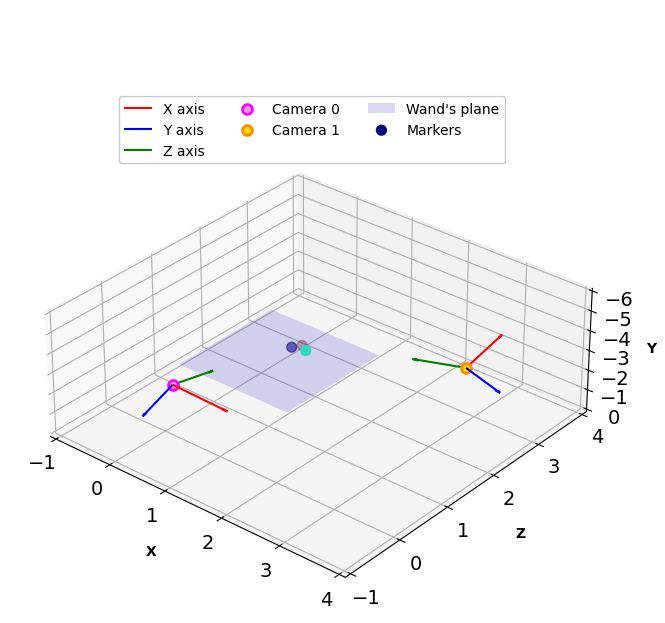

In [58]:
# triangulate ordered centroids from the first pair
pts1,pts2 = np.copy(dfOrig[0][0:6].reshape(-1,2)),np.copy(dfOrig[1][0:6].reshape(-1,2))
R,t,lamb = rotation[1],translation[1].reshape(-1,3),scale[1]
P1,P2 = np.hstack((cameraMat[0], [[0.], [0.], [0.]])),np.matmul(cameraMat[1], np.hstack((R, t.T)))
projPt1,projPt2 = myProjectionPoints(np.array(pts1)),myProjectionPoints(np.array(pts2))
points4d = triangulatePoints(P1.astype(float),P2.astype(float),projPt1.astype(float),projPt2.astype(float))
points3d = (points4d[:3, :]/points4d[3, :]).T
if points3d[0, 2] < 0: points3d = -points3d
points3d = points3d*lamb/100

# get ground plane coefficients
plane = findPlane(points3d[0],points3d[1],points3d[2])
if np.any(plane[0:3]<0): plane = findPlane(points3d[0],points3d[2],points3d[1])
[a,b,c,d]=plane
# get the orthonogal vector to the plane
v,k=np.array([a,b,c]),np.array([0,1,0])
# compute the angle between the plane and the y axis
cosPhi = np.dot(v,k)/(np.linalg.norm(v)*np.linalg.norm(k))
# compute the versors
[u1,u2,u3] = np.cross(v,k)/np.linalg.norm(np.cross(v,k))
# get the rotation matrix and new ground plane coefficients
sinPhi = np.sqrt(1-pow(cosPhi,2))
R_plane = np.array([
        [cosPhi+u1*u1*(1-cosPhi),u1*u2*(1-cosPhi)-u3*sinPhi,u2*sinPhi+u1*u3*(1-cosPhi)],
        [u1*u2*(1-cosPhi)+u3*sinPhi,cosPhi+u2*u2*(1-cosPhi),u2*u3*(1-cosPhi)-u1*sinPhi],
        [u1*u3*(1-cosPhi)-u2*sinPhi,u2*u3*(1-cosPhi)+u1*sinPhi,cosPhi+u3*u3*(1-cosPhi)]])
[A,B,C] = np.matmul(R_plane,np.array([a,b,c]).T)
newPlane = np.array([A,B,C])

# setting 3D plot variables
fig = plt.figure(figsize=(8, 8),dpi=100)
ax = plt.axes(projection='3d')
ax.set_xlim(-1, 4)
ax.set_zlim(-6, 0)
ax.set_ylim(-1, 4)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_xlabel('X', fontweight='bold',labelpad=15)
ax.set_ylabel('Z', fontweight='bold',labelpad=15)
ax.set_zlabel('Y', fontweight='bold',labelpad=5)
cmhot = plt.get_cmap("jet")
ax.view_init(elev=30, azim=-50) 
plt.gca().invert_zaxis()
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1., 1., .5, 1.]))
colours = [['fuchsia','plum'],['darkorange','gold'],['limegreen','greenyellow'],['blue','lightsteelblue']]

# initializing arrays
zDisplacement = 0
P_plane = np.vstack((np.hstack((R_plane,np.array([0,0,0]).reshape(3,-1))),np.hstack((np.zeros((3)),1))))

# plot each camera translated and rotated to meet the ground plane
for j in range(nCameras):
    o = np.matmul(projMat[j],[[0.],[0],[0.],[1]]).ravel()
    o+= [0,+d/b,0,0]
    o = np.matmul(P_plane,o).ravel()
    if not j: zDisplacement = o[2]
    o+= [0,0,-zDisplacement,0]
    x,y,z= np.array([1, 0, 0, 0]), np.array([0, 1, 0, 0]),np.array([0, 0, 1, 0])
    x,y,z = np.matmul(projMat[j],x),np.matmul(projMat[j],y),np.matmul(projMat[j],z)
    x,y,z = np.matmul(P_plane,x),np.matmul(P_plane,y),np.matmul(P_plane,z)
    ax.quiver(o[0], o[2], o[1], x[0], x[2], x[1], arrow_length_ratio=0.1, edgecolors="r", label='X axis')
    ax.quiver(o[0], o[2], o[1], y[0], y[2], y[1], arrow_length_ratio=0.1, edgecolors="b", label='Y axis')
    ax.quiver(o[0], o[2], o[1], z[0], z[2], z[1], arrow_length_ratio=0.1, edgecolors="g", label='Z axis')
    ax.scatter(o[0], o[2], o[1], s=50, edgecolor=colours[j][0], facecolor=colours[j][1], linewidth=2,  label = 'Camera '+str(j))
    
# plot the ground plane
x,z = np.linspace(-1,1,30),np.linspace(3,5,10)
X,Z = np.meshgrid(x,z)
Y=(-newPlane[0]*X -newPlane[2]*Z)/newPlane[1]
surf = ax.plot_surface(X,Z-zDisplacement,Y,color='b',alpha=.15,label="Wand's plane")
surf._facecolors2d = surf._facecolor3d
surf._edgecolors2d = surf._edgecolor3d
# plot markers
points3d = np.hstack((points3d,np.ones((points3d.shape[0],1))))
points3d+= [0,d/b,0,0]
points3d = np.matmul(P_plane,points3d.T).T
points3d+= [0,0,-zDisplacement,0]
points3d = points3d.T
ax.scatter(points3d[0], points3d[2], points3d[1], s=50, c=points3d[2], cmap=cmhot, label= 'Markers')

# axis setup and plot variables
first3Dpoints = points3d.copy()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),ncol=3,loc ='center',edgecolor='silver', bbox_to_anchor=(0.5, 0.8))
plt.draw()
plt.show()

### Correction matrices

Since **there are errors in the focal distance** calibration, there will be errors when matching the clouds from different pairs of camera. But we can compute the rotation and translation from each point cloud to the point cloud of the pair 0-1. 

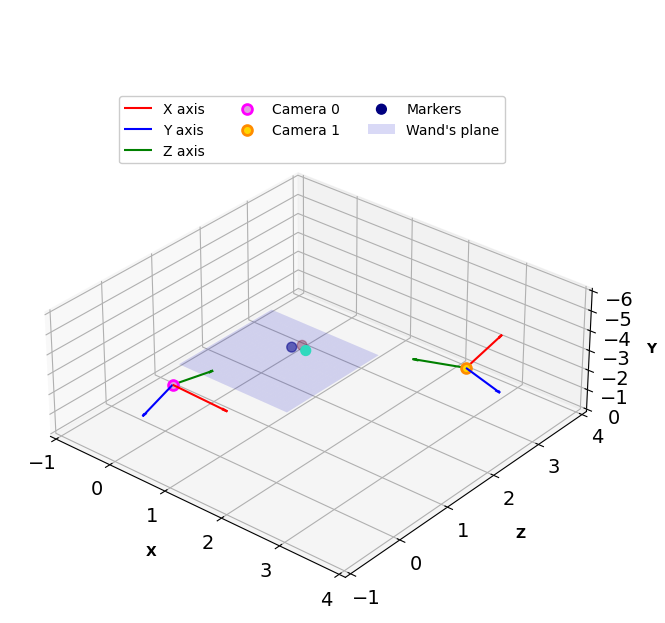

In [59]:
# setting 3D plot variables
fig = plt.figure(figsize=(8, 8),dpi=100)
ax = plt.axes(projection='3d')
ax.set_xlim(-1, 4)
ax.set_zlim(-6, 0)
ax.set_ylim(-1, 4)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_xlabel('X', fontweight='bold',labelpad=15)
ax.set_ylabel('Z', fontweight='bold',labelpad=15)
ax.set_zlabel('Y', fontweight='bold',labelpad=5)
cmhot = plt.get_cmap("jet")
ax.view_init(elev=30, azim=-50) 
plt.gca().invert_zaxis()
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1., 1., .5, 1.]))
colours = [['fuchsia','plum'],['darkorange','gold'],['limegreen','greenyellow'],['blue','lightsteelblue']]

# plot each camera translated and rotated to meet the ground plane
for j in range(nCameras):
    o = np.matmul(projMat[j],[[0.],[0],[0.],[1]]).ravel()
    o+= [0,+d/b,0,0]
    o = np.matmul(P_plane,o).ravel()
    o+= [0,0,-zDisplacement,0]
    x,y,z= np.array([1, 0, 0, 0]), np.array([0, 1, 0, 0]),np.array([0, 0, 1, 0])
    x,y,z = np.matmul(projMat[j],x),np.matmul(projMat[j],y),np.matmul(projMat[j],z)
    x,y,z = np.matmul(P_plane,x),np.matmul(P_plane,y),np.matmul(P_plane,z)
    ax.quiver(o[0], o[2], o[1], x[0], x[2], x[1], arrow_length_ratio=0.1, edgecolors="r", label='X axis')
    ax.quiver(o[0], o[2], o[1], y[0], y[2], y[1], arrow_length_ratio=0.1, edgecolors="b", label='Y axis')
    ax.quiver(o[0], o[2], o[1], z[0], z[2], z[1], arrow_length_ratio=0.1, edgecolors="g", label='Z axis')
    ax.scatter(o[0], o[2], o[1], s=50, edgecolor=colours[j][0], facecolor=colours[j][1], linewidth=2,  label = 'Camera '+str(j))

# plot the 3d points of the first camera
ax.scatter(first3Dpoints[0], first3Dpoints[2], first3Dpoints[1], s=50, c=first3Dpoints[2], cmap=cmhot, label= 'Markers')
correcMat = []

# plot the matching 3d points for the other cameras
for j in range(1,nCameras-1):
    # get data
    pts1,pts2 = dfOrig[j][0:6].reshape(-1,2),dfOrig[j+1][0:6].reshape(-1,2)
    F = FMatrix[j]
    R,t,lamb = rotation[j+1],translation[j+1].reshape(-1,3),scale[j+1]
    P1,P2 = np.hstack((cameraMat[j], [[0.], [0.], [0.]])),np.matmul(cameraMat[j+1], np.hstack((R, t.T)))
    projPt1,projPt2 = myProjectionPoints(np.array(pts1)),myProjectionPoints(np.array(pts2))
    # triangulate points
    points4d = triangulatePoints(P1.astype(float),P2.astype(float),projPt1.astype(float),projPt2.astype(float))
    points3d = (points4d[:3, :]/points4d[3, :]).T
    if points3d[0, 2] < 0: points3d = -points3d
    # displacement 
    points3d = np.hstack((points3d*scale[j+1][0]/100,np.ones((points3d.shape[0],1)))).T
    points3d = np.matmul(projMat[j],points3d).T
    points3d+= [0,d/b,0,0]
    points3d = np.matmul(P_plane,points3d.T).T
    points3d+= [0,0,-zDisplacement,0]
    # compute correction amtrix
    ptA,ptB = np.copy(points3d.T[0:3]),np.copy(first3Dpoints[0:3])
    R,t = findRandT(ptA,ptB,3)
    P = np.vstack((np.hstack((R,t.reshape(-1,1))),np.hstack((np.zeros((3)),1))))
    # save projection matrix
    correcMat.append(P)
    # rotate points and plot
    points3d = np.matmul(P,points3d.T).T
    points3d = points3d.T
    ax.scatter(points3d[0], points3d[2], points3d[1], s=50, c=points3d[2], cmap=cmhot, label= 'Markers')

# plot the ground plane
x,z = np.linspace(-1,1,30),np.linspace(3,5,10)
X,Z = np.meshgrid(x,z)
Y=(-newPlane[0]*X -newPlane[2]*Z)/newPlane[1]
surf = ax.plot_surface(X,Z-zDisplacement,Y,color='b',alpha=.15,label="Wand's plane")
surf._facecolors2d = surf._facecolor3d
surf._edgecolors2d = surf._edgecolor3d

# axis setup and plot variables
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),ncol=3,loc ='center',edgecolor='silver', bbox_to_anchor=(0.5, 0.8))
plt.draw()
plt.show()

## Testing flight

The following cell sets up the name of the CSV where the data is stored and the size of the arrays to be read. Alter to the values used with the `serverv2Test.py` code.

In [61]:
##########################################
### YOU MAY CHANGE THE VARIABLES BELOW ###
##########################################

# name (folder/camTest.csv) where the CSV from serverv2Test.py is saved
dfCSV = np.genfromtxt('G:/Meu Drive/UFCG/Mestrado/MoCap/CSV datasets/7Jun/camTest_50cmSquare_only4Blobs.csv', delimiter=',')
recTime = 60    # recording time, in seconds
step = 1/100    # step of the interpolated DF

In [69]:
#########################
### Utility functions ###
#########################

import time

# order blobs per proximity
def getTheClosest(coordNow, prev):
    # get data into the correct shape
    centerCoord,prevCenterCoord = np.copy(coordNow).reshape(-1,2),np.copy(prev).reshape(-1,2)
    newOrder,nMarkers = np.ones(centerCoord.shape[0],dtype=np.int8)*-1,centerCoord.shape[0]
    # order each blob
    for i in range(nMarkers):
        # check if blob has already been ordered
        if newOrder[i] == -1:
            # get distance from previous images blobs to actual image
            pt = prevCenterCoord[i]        
            distNow = np.linalg.norm(centerCoord-pt,axis=1)
            retNow = distNow < 5
            # if any blob is closer than 5 px, that is the one
            if np.sum(retNow) == 1: newOrder[i] = np.argmin(distNow)
            else:              
                # if more than 1 one or 0 are close than 5px, get the one with the smaller distance
                allPermuationsOf4,allDists = np.array(list(permutations(list(range(0,4))))),[]
                # get all possible distances between last and actual iamges blobs
                for idx in allPermuationsOf4:
                    newPts,dist = centerCoord[idx],0
                    for k in range(nMarkers): 
                        aux= np.linalg.norm(prevCenterCoord[k]-newPts[k])
                        dist+=aux
                    allDists.append(dist)
                # get minimum distance
                minDist = np.argmin(allDists)
                choosenIdx = allPermuationsOf4[minDist]
                return choosenIdx
    return newOrder

# interpolate data using cubic spline
def myInterpolate(coord,ts,step):
    # get data
    if not len(ts): return [],[]
    # get array limits
    lowBound,highBound = math.ceil(ts[0]/step),math.floor(ts[-1]/step)
    # interpolate
    tNew = np.linspace(lowBound,highBound,int((highBound-lowBound))+1,dtype=np.uint16)
    ff = CubicSpline(ts,coord,axis=0)
    return ff(tNew*step),tNew

# returns if neighbor camera has captured a point at that timestamp
def getOtherValidIdx(line,nMarkers,idx,relateLast2First = 0):
    nCameras = int(line.shape[0]/2/nMarkers)
    nColumns = 2*nMarkers
    valid = [np.any(line[i*nColumns:i*nColumns+nColumns]) for i in [(idx-1)%nCameras,(idx+1)%nCameras]]
    res = np.array([(idx-1)%nCameras,(idx+1)%nCameras])[np.where(valid)[0]]
    if not relateLast2First and nCameras!=2: 
        if idx == 0: res = np.delete(res,np.where(res == (nCameras-1))[0])
        elif idx == (nCameras-1): res = np.delete(res,np.where(res == 0)[0])
    return res

# create dictionary that keeps track of ordering need with neighbor camera
def createNeedsOrder(nCameras,relateLast2First = 0):
    needsOrder = {}
    for i in range(nCameras):
        # if the last camera is calibrated as a pair to the first one
        if relateLast2First:
            if not i: needsOrder[str(i)]=np.array([nCameras-1,i+1])
            elif i == (nCameras-1): needsOrder[str(i)]=np.array([i-1,0])
            else: needsOrder[str(i)]=np.array([i-1,i+1])
        else:
            if not i: needsOrder[str(i)]=np.array([i+1])
            elif i == (nCameras-1): needsOrder[str(i)]=np.array([i-1])
            else: needsOrder[str(i)]=np.array([i-1,i+1])
    return needsOrder

# resets the ordering array at one camera index
def activateNeedsOrder(nCameras, idx, needsOrder, relateLast2First = 0):
    if not idx:
        # add the vector to the camera at idx
        if relateLast2First: 
            needsOrder[str(idx)]=np.array([nCameras-1,idx+1])
            needsOrder[str(nCameras-1)]=np.unique(np.hstack((needsOrder[str(nCameras-1)],[0])))
        else: needsOrder[str(idx)]=np.array([idx+1])
        # add to the neighbor camera that idx needs ordering
        needsOrder[str(idx+1)]=np.unique(np.hstack((needsOrder[str(idx+1)],[idx])))
    elif idx == (nCameras-1):
        if relateLast2First: 
            needsOrder[str(idx)]=np.array([idx-1,0])
            needsOrder[str(0)]=np.unique(np.hstack((needsOrder[0],[nCameras-1])))
        else: needsOrder[str(idx)]=np.array([idx-1])
        needsOrder[str(idx-1)]=np.unique(np.hstack((needsOrder[str(idx-1)],[idx])))
    else:
        needsOrder[str(idx)]=np.array([idx-1,idx+1])
        needsOrder[str(idx+1)]=np.unique(np.hstack((needsOrder[str(idx+1)],[idx])))
        needsOrder[str(idx-1)]=np.unique(np.hstack((needsOrder[str(idx-1)],[idx])))
    return needsOrder

# removes indexes from neighbor camera (they have been ordered)
def popNeedsOrder(idx, otherIdx, needsOrder):
    # delete from idx
    myVec = np.array(needsOrder[str(idx)])
    idx2Delete = np.where(myVec==otherIdx)[0]
    needsOrder[str(idx)] = np.delete(myVec,idx2Delete)
    # delete from otherIdx
    myVec = np.array(needsOrder[str(otherIdx)])
    idx2Delete = np.where(myVec==idx)[0]
    needsOrder[str(otherIdx)] = np.delete(myVec,idx2Delete)
    return needsOrder

# get angle between two vectors
def getAngle(a,b):
    cosPhi = np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
    phi = np.arccos(cosPhi)
    return np.arctan2(np.sin(phi),cosPhi)


### Reading coordinates, ordering and triangulating markers

Now we do ordering and triangulation inside the reading loop. The epiline approach for ordering tests 16 possibilities at each loop, so we keep track of the camera pairs that needs ordering of the centroids. When at least one image is ordered, the blobs in following ones are tracked by proximity. The reference is reset if more than 10 images are invalid (per time missmatch or occlusion)

Nevertheless, we can only relate the two cameras when all four markers are visible at the same time. We do as following:

- Wait for the cameras to have at least 3 images in storage for the actual valid interval.
- Check which cameras still need to be related to the one that sent the last package.
- If yes, check if valid time interval of this other camera has intesection with that camera that sent the last package.
- If yes, we order the blobs at the first intersection timestamp per epipolar line.
- Then we flip the blobs according to this order on the second camera (sorted by index) in the non interpolated database since the beggining fo the actual valid time interval.
- We notify that any camera index comming after this second camera index also needs reordering when the next package is received.

Then, for triangulation, we follow as:

- Wait for the cameras to have at least 10 images in storage for the actual valid interval to start triangulating
- Interpolate the blobs that have not been already interpolated.
- Check if any of the interpolated images are also seen by any other camera (always neighbours).
- Triangulate markers with this camera (including projection matrix, ground plane rotation and correction matrix).


In [72]:
# initiating empty arrays
counter,i,lastTime = np.zeros(nCameras,dtype=np.int32),0,np.zeros(nCameras,dtype=np.int32)
missed,invalid,swap = np.zeros(nCameras,dtype=np.int32),np.zeros(nCameras,dtype=np.int32),np.zeros(nCameras,dtype=np.int32)
lastImgNumber = np.zeros(nCameras,dtype=np.int32)
intervals,lastTnew = [],[]
dfOrig,nPrevious,warmUp = [],3,10 # warm up > n previous
needsOrder = createNeedsOrder(nCameras,relateLast2First=0)
allPoints3d = []
verbose = False
for k in range(nCameras):
    dfOrig.append([])
    intervals.append([])
    lastTnew.append([])
dfInterp = np.zeros((int(recTime/step),nCameras*8+2))
dfInterp[:,-2] = np.arange(0,recTime,step)
dfInterp[:,-1] = np.zeros_like(dfInterp[:,-1],dtype=np.bool8)
dfTriang = np.zeros((int(recTime/step),4*4+1))
dfTriang[:,-1] = np.arange(0,recTime,step)
timeArray = []

# test loop done in real time
while i!=dfCSV.shape[0]:
    # just to measure loop time
    start = time.time()
    line = dfCSV[i]
    idx = int(line[10])
    # get data from the line
    undCoord,timeNow,imgNumber = line[0:8].reshape(-1,2),line[8],line[9]
    i+=1
    # if ts if not read corectly, discard
    if counter[idx]:
        if abs(timeNow-lastTime[idx])>1e9: 
            if verbose: print('time missmatch')
            missed[idx]+=1
            invalid[idx]+=1
            continue
    # check if sequence is valid
    if imgNumber>lastImgNumber[idx]+1: invalid[idx] = imgNumber-lastImgNumber[idx]
    # check occlusion and order markers per proximity
    if not isEqual(undCoord,5) and not np.any(undCoord<0):     
        if invalid[idx]>=10 or not counter[idx]: 
            if verbose: print('reseting at camera', idx,', counter',counter[idx],',',timeNow/1e6,'s')
            prev,needsOrder = [],activateNeedsOrder(nCameras,idx,needsOrder,relateLast2First=0)
            intervals[idx].append(counter[idx])
        else:
            if not (counter[idx]-1): prev = np.array(dfOrig[idx][0:8]).reshape(-1,2)
            else: prev = np.array(dfOrig[idx][-1,0:8]).reshape(-1,2)
            newOrder = getTheClosest(undCoord.reshape(-1,2),prev.reshape(-1,2))
            undCoord = np.copy(undCoord[newOrder])
    else: 
        if verbose: print('not collinear or equal centroids')
        missed[idx]+=1
        invalid[idx]+=1
        continue
    # update loop variables
    lastTime[idx],lastImgNumber[idx],invalid[idx] = timeNow,imgNumber,0    
    if not counter[idx]: dfOrig[idx] = np.hstack((undCoord.reshape(8),timeNow))
    else: dfOrig[idx] = np.vstack((dfOrig[idx],np.hstack((undCoord.reshape(8),timeNow))))
    counter[idx]+=1
    # interpolate
    if needsOrder[str(idx)].size:
        # get is there are enough points at the valid interval
        for otherIdx in needsOrder[str(idx)]:
            if not len(intervals[otherIdx]): continue
            myCounter,myIntervals = np.array([counter[idx],counter[otherIdx]]),np.array([intervals[idx][-1],intervals[otherIdx][-1]])            
            if np.all(myCounter-myIntervals>=nPrevious):
                # see if there are intersection between arrays
                ts1,ts2 = dfOrig[idx][intervals[idx][-1]:counter[idx],8]/1e6,dfOrig[otherIdx][intervals[otherIdx][-1]:counter[otherIdx],8]/1e6
                validIdx1 = [k for k in range(0,len(ts1)) if max(ts1[0], ts2[0])-0.01<=ts1[k]<=min(ts1[-1], ts2[-1])+0.01]
                validIdx2 = [k for k in range(0,len(ts2)) if max(ts1[0], ts2[0])-0.01<=ts2[k]<=min(ts1[-1], ts2[-1])+0.01]
                # if there is intersection, get order
                if len(validIdx1) and len(validIdx2):
                    ts1,ts2 = np.copy(ts1[validIdx1]),np.copy(ts2[validIdx2])
                    if ts1.shape[0]<2 or ts2.shape[0]<2: continue
                    coord1,coord2 = dfOrig[idx][intervals[idx][-1]:counter[idx],0:8],dfOrig[otherIdx][intervals[otherIdx][-1]:counter[otherIdx],0:8]
                    coord1,coord2 = np.copy(coord1[validIdx1]),np.copy(coord2[validIdx2])
                    # get interpolated data
                    interp1,tNew1 = myInterpolate(coord1,ts1,step)
                    interp2,tNew2 = myInterpolate(coord2,ts2,step)
                    if not len(interp1) or not len(interp2): continue
                    # get min and max idx
                    minIdx,maxIdx = min(idx,otherIdx),max(idx,otherIdx)
                    # get common idx
                    F = FMatrix[minIdx]
                    interpolateIdx1,interpolateIdx2 = np.argmax(np.in1d(tNew1, tNew2)),np.argmax(np.in1d(tNew2, tNew1))
                    # order per epipolar line
                    if idx < otherIdx: orderSecondFrame,ret = getOrderPerEpiline(interp1[-1],interp2[-1],4,F,0,1)
                    else: orderSecondFrame,ret = getOrderPerEpiline(interp2[-1],interp1[-1],4,F,0,1)
                    if not ret: 
                        if verbose: print(minIdx,maxIdx,'could not rearange at',tNew2[-1]*step,'s')
                        continue
                    # get interval to rearrange
                    if verbose: print(minIdx,maxIdx,'rearanging interval',[intervals[maxIdx][-1],counter[maxIdx]], 'to', orderSecondFrame, 'at',tNew2[-1]*step,'s')
                    # flip blobs
                    for k in range(intervals[maxIdx][-1],counter[maxIdx]):
                       dfOrig[maxIdx][k,0:8] = np.copy(dfOrig[maxIdx][k,0:8].reshape(-1,2)[orderSecondFrame].reshape(-8))
                    # change ordering boolean
                    needsOrder=popNeedsOrder(idx,otherIdx,needsOrder)
                    for k in range(maxIdx+1,nCameras):
                        needsOrder=activateNeedsOrder(nCameras,k,needsOrder,relateLast2First=0) 
    if (counter[idx]-intervals[idx][-1])>=warmUp: 
        # get data to interpolate
        coord,ts = dfOrig[idx][(counter[idx]-warmUp):counter[idx],0:8],dfOrig[idx][(counter[idx]-warmUp):counter[idx],8]/1e6
        if not len(ts): continue
        lowBound,highBound = math.ceil(ts[0]/step),math.floor(ts[-1]/step)
        # avoid repeating intepolation
        if lastTnew[idx]:
            if lowBound<lastTnew[idx]: lowBound = lastTnew[idx]+1
        # interpolate
        tNew = np.linspace(lowBound,highBound,int((highBound-lowBound))+1,dtype=np.uint16)
        ff = CubicSpline(ts,coord,axis=0)
        # save data
        dfInterp[tNew,int(idx*8):int(idx*8+8)] = ff(tNew*step)
        lastTnew[idx] = tNew[-1]
        # compare if there is another camera available
        for k in tNew:
            if dfInterp[k,-1]: continue
            otherIdx = getOtherValidIdx(dfInterp[k,:],4,idx)      
            #print(k,otherIdx)
            if not len(otherIdx) or otherIdx in needsOrder[str(idx)]: continue      
            # get index from the other camera
            dfInterp[k,-1],otherIdx = True,otherIdx[0]
            # comparing the indexes to set the projection matrices
            minIdx,maxIdx = min(idx,otherIdx),max(idx,otherIdx)
            # getting the data
            pts1,pts2 = dfInterp[k,minIdx*8:(minIdx+1)*8].reshape(-1,2),dfInterp[k,maxIdx*8:(maxIdx+1)*8].reshape(-1,2)
            R,t,lamb = rotation[maxIdx],translation[maxIdx].reshape(-1,3),scale[maxIdx]
            P1,P2 = np.hstack((cameraMat[minIdx], [[0.], [0.], [0.]])),np.matmul(cameraMat[maxIdx], np.hstack((R, t.T)))
            projPt1,projPt2 = myProjectionPoints(np.array(pts1)),myProjectionPoints(np.array(pts2))
            # triangulate
            points4d = triangulatePoints(P1.astype(float),P2.astype(float),projPt1.astype(float),projPt2.astype(float))
            points3d = (points4d[:3, :]/points4d[3, :]).T
            if points3d[0, 2] < 0: points3d = -points3d  
            # project in scale regarding the minimum index camera
            points3d = np.hstack((points3d*lamb/100,np.ones((points3d.shape[0],1)))).T
            points3d = np.matmul(projMat[minIdx],points3d).T
            # rotate to ground plane
            points3d+= [0,d/b,0,0]
            points3d = np.matmul(P_plane,points3d.T).T
            points3d+= [0,0,-zDisplacement,0]
            points3d = points3d.T
            # apply correction matrix
            if minIdx: points3d = np.matmul(correcMat[minIdx-1],points3d)
            points3d = points3d.T
            # save to array
            dfTriang[k,0:16] = np.copy(points3d.ravel())
            if not len(allPoints3d): allPoints3d = np.copy(points3d)
            else: allPoints3d = np.vstack((allPoints3d,points3d)) 
            #print(minIdx,maxIdx,round(k*0.01,2),points3d[0])

    timeArray.append(time.time()-start)

# just comprising dataset if wanted to plot
emptyLines = np.unique([i for i in range(0,dfInterp.shape[0]) if not dfInterp[i][-1]])
dfInterp = np.delete(dfInterp,emptyLines,axis=0)
dfTriang = np.delete(dfTriang,emptyLines,axis=0)
print('[INFO] found ' +str(dfTriang.shape[0])+ ' interpolated pics')
# time plot for further temporal analysis
print('[INFO] Temporal analysis')
print('\t> Min:',round(np.min(timeArray),5),'s')
print('\t> Mean:',round(np.mean(timeArray),5),'s')
print('\t> Max:',round(np.max(timeArray),5),'s')
print('\t> Std. Dev.:',round(np.std(timeArray),5),'s')
allPoints3d = allPoints3d.T

# plot debug for interpolated dataset
'''for idx in range(nCameras):
    os.system('del -rf pics\cam'+str(idx+1)+'\*jpg')
    for j in range(0,dfInterp.shape[0]):
        pts,name,img,k = dfInterp[j,int(idx*8):int(idx*8+8)].reshape(-1,2),int(dfInterp[j,-2]/step),np.ones((720,960,3))*255,0
        for k in range(0,4):
            pt = pts.reshape(-1,2)[k]
            center = (int(np.round(pt[0]*16)),int(np.round(pt[1]*16)))
            circle(img,center,10,(255,0,0),5,shift=4)
            putText(img,str(k),(int(center[0]/16)-25, int(center[1]/16)-25),FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2) 
        imwrite('pics/cam'+str(idx+1)+'/'+str(name).zfill(20)+'.jpg',img)''';


[INFO] found 2569 interpolated pics
[INFO] Temporal analysis
	> Min: 0.0 s
	> Mean: 0.00042 s
	> Max: 0.009 s
	> Std. Dev.: 0.00057 s


### Visual plot and anaylisis

The following cells plot the 3D mat and 2D analysis of the data captured during the test live loop.

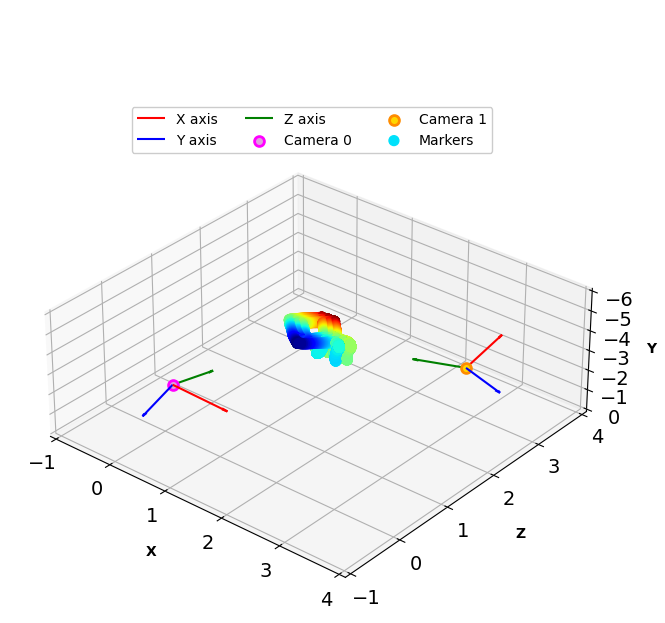

In [73]:
# setting 3D plot variables
fig = plt.figure(figsize=(8, 8),dpi=100)
ax = plt.axes(projection='3d')
ax.set_xlim(-1, 4)
ax.set_zlim(-6, 0)
ax.set_ylim(-1, 4)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_xlabel('X', fontweight='bold',labelpad=15)
ax.set_ylabel('Z', fontweight='bold',labelpad=15)
ax.set_zlabel('Y', fontweight='bold',labelpad=5)
cmhot = plt.get_cmap("jet")
ax.view_init(elev=30, azim=-50) 
plt.gca().invert_zaxis()
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1., 1., .5, 1.]))
colours = [['fuchsia','plum'],['darkorange','gold'],['limegreen','greenyellow'],['blue','lightsteelblue']]

# plot each camera translated and rotated to meet the ground plane
for j in range(nCameras):
    o = np.matmul(projMat[j],[[0.],[0],[0.],[1]]).ravel()
    o+= [0,+d/b,0,0]
    o = np.matmul(P_plane,o).ravel()
    o+= [0,0,-zDisplacement,0]
    x,y,z= np.array([1, 0, 0, 0]), np.array([0, 1, 0, 0]),np.array([0, 0, 1, 0])
    x,y,z = np.matmul(projMat[j],x),np.matmul(projMat[j],y),np.matmul(projMat[j],z)
    x,y,z = np.matmul(P_plane,x),np.matmul(P_plane,y),np.matmul(P_plane,z)
    ax.quiver(o[0], o[2], o[1], x[0], x[2], x[1], arrow_length_ratio=0.1, edgecolors="r", label='X axis')
    ax.quiver(o[0], o[2], o[1], y[0], y[2], y[1], arrow_length_ratio=0.1, edgecolors="b", label='Y axis')
    ax.quiver(o[0], o[2], o[1], z[0], z[2], z[1], arrow_length_ratio=0.1, edgecolors="g", label='Z axis')
    ax.scatter(o[0], o[2], o[1], s=50, edgecolor=colours[j][0], facecolor=colours[j][1], linewidth=2,  label = 'Camera '+str(j))

# plot points after correction matrix
ax.scatter(allPoints3d[0], allPoints3d[2], allPoints3d[1], s=50, c=allPoints3d[2], cmap=cmhot, label= 'Markers')

# axis setup and plot variables
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),ncol=3,loc ='center',edgecolor='silver', bbox_to_anchor=(0.5, 0.8))
plt.draw()
plt.show()

# save array of each point for later use (e.g. Matlab)
'''for k in range(0,4):
    idx = np.array(range(k,allPoints3d.shape[1],4)).astype(int)
    points3dNew = allPoints3d.T[idx]
    # plor min and maximum height
    print('marker',k,'max',-min(points3dNew[:,1]),'m,','min',-max(points3dNew[:,1]),'m')
    #np.savetxt('points3d'+str(k)+'.csv',points3dNew,delimiter=',')''';

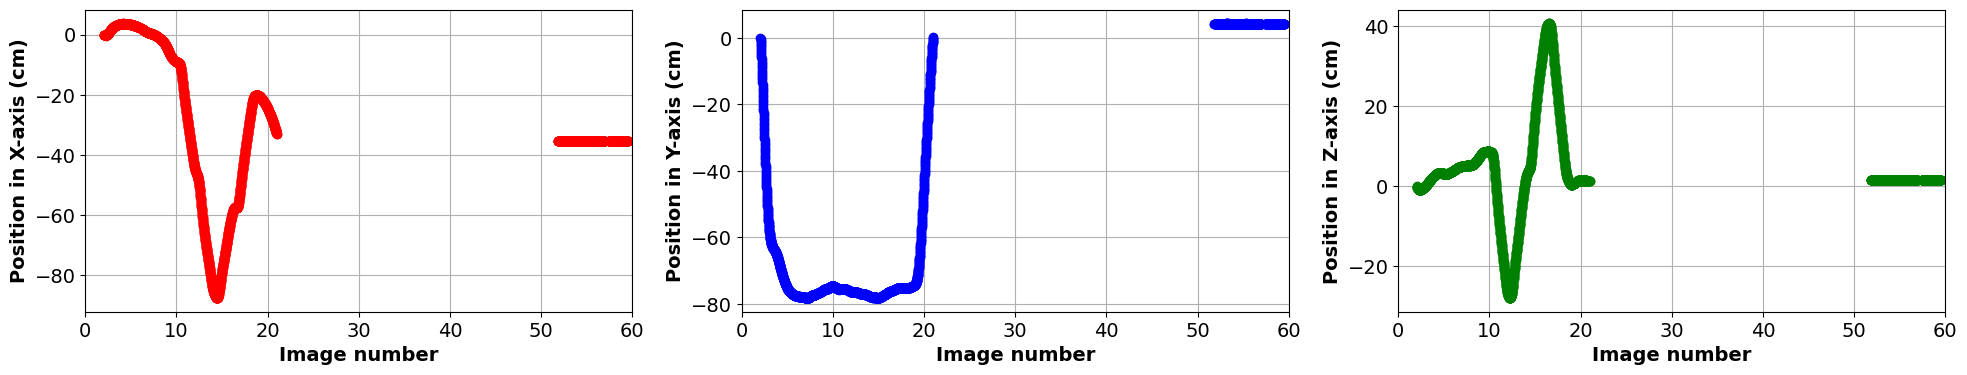

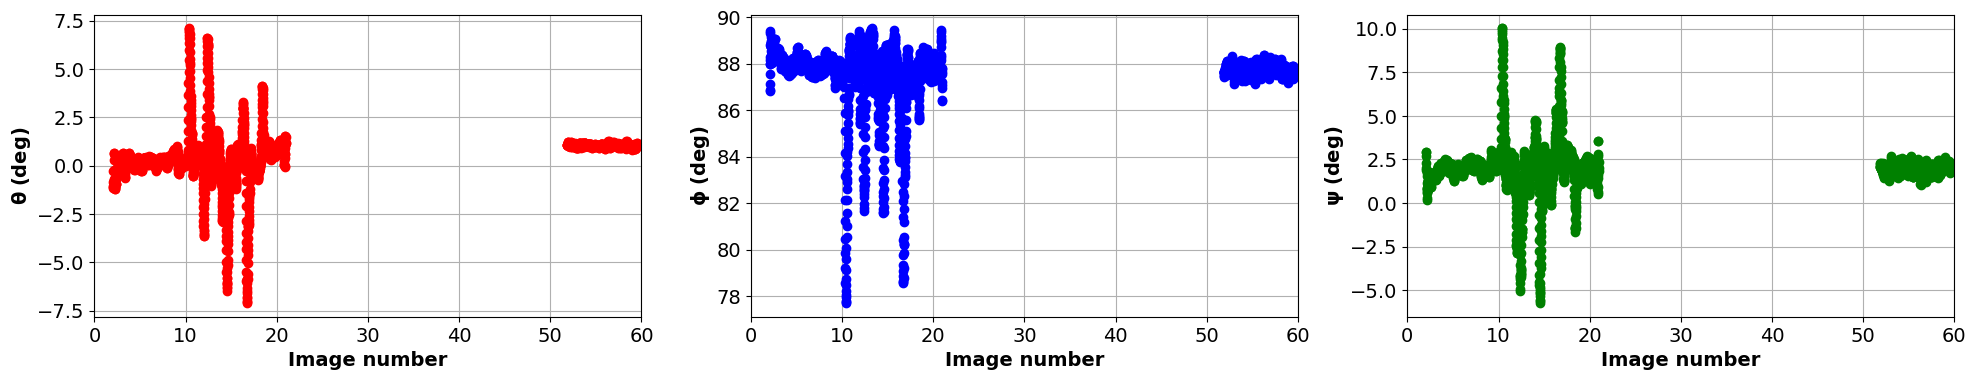

In [75]:
# initialize variables
allCombinationsOf2 = np.array(list(combinations(list(range(0,4)),2)))
points3d_rightTriangle = []
points3d_centreOfMass = []
deleteIdx = []

# get position per axis
for k in range(0,dfTriang.shape[0]):
    # initialize variables
    pts,myNorm,ts = dfTriang[k,0:-1].reshape(-1,4)[:,0:3],[],dfTriang[k,-1]
    # get the distance between blobs
    for idx in allCombinationsOf2:
        myNorm.append(np.linalg.norm(np.diff(pts[idx],axis=0)))
    orderedNorm = np.argsort(myNorm)
    # the blobs furthest apart are the vertices of the triangle
    myIdx = np.unique([allCombinationsOf2[orderedNorm[-1]],allCombinationsOf2[orderedNorm[-2]]])
    centreOfMass = [i for i in range(0,4) if i not in myIdx]
    # save do array
    if not len(points3d_rightTriangle): 
         points3d_centreOfMass = pts[centreOfMass]
         points3d_rightTriangle = pts[myIdx]
    else: 
        points3d_centreOfMass = np.vstack((points3d_centreOfMass,pts[centreOfMass]))
        points3d_rightTriangle = np.vstack((points3d_rightTriangle,pts[myIdx]))
# plotting variables
fig, axs = plt.subplots(1,3,figsize=(24,4),dpi=100)
colour = ['r','b','g']
label = ['Position in X-axis (cm)','Position in Y-axis (cm)','Position in Z-axis (cm)']
for k in range(0,3):
    axs[k].plot(dfTriang[:,-1],
                (points3d_centreOfMass[:,k]-points3d_centreOfMass[0,k])*100,
                'o',c=colour[k],linewidth=3)
    axs[k].set_xlim((0,recTime))
    axs[k].grid(True)
    axs[k].set_ylabel(label[k],fontweight='bold',size=14)
    axs[k].set_xlabel('Image number',fontweight='bold',size=14)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14

# get orientation
myOrientation = []
for k in range(0,int(points3d_rightTriangle.shape[0]/3)):
    # get the coordinates of the vertices of the triangles
    pts = points3d_rightTriangle[k*3:k*3+3]
    # get orthogonal vector and angles
    n = np.cross(pts[1]-pts[0], pts[2]-pts[0])
    nNormalised = n / np.linalg.norm(n)
    angles = np.rad2deg(np.arcsin(nNormalised))
    # save array
    if not len(myOrientation): myOrientation = [angles]
    else: myOrientation = np.vstack((myOrientation,[angles]))
# plotting variables
fig, axs = plt.subplots(1,3,figsize=(24,4),dpi=100)
colour = ['r','b','g']
label = [r'$\mathbf{\theta\;(deg)}$',r'$\mathbf{\phi\;(deg)}$',r'$\mathbf{\psi\;(deg)}$']
for k in range(0,3):
    axs[k].plot(dfTriang[:,-1],myOrientation[:,k],'o',c=colour[k],linewidth=3)
    axs[k].set_xlim((0,recTime))
    axs[k].grid(True)
    axs[k].set_ylabel(label[k],size=14,labelpad=3)
    axs[k].set_xlabel('Image number',fontweight='bold',size=14)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14